# CSC424 - Machine Learning - Assignment 4

<br>

### Team - Random Access Memories
> #### Rivu Bhattacharjee — 1910626
> #### Ahnaf Abdullah — 2130223
> #### Tausia Tahsin Nuzum — 2221415



## Assignment 4A (CAM) -- 75% marks

#### Problem Statement

1. Use MNIST Fashion dataset

2. Now we have to modify the following architecture for CAM so that you can see the class-wise attentions for input image.

3. Apply GAP on the last layer just before the FC1.

4. Then add only one FC layer for the output (Australian Terried as shown in page 8-10 in Lecture 5.1).

5. Train with your train data. Plot training loss, validation loss for learning rate 0.001 and batch size: 1024/2048 (Which one was best from assignment 3).

6. Run the test on the test split and report confusion matrix and the F1 scores for your test data. Compare your performance with assignment 3

7. Now pick 10 test data (where predictions are right) from 10 classes, pass them through the trained network, produce attention map (CAM) for the input images. Show the input images and attention maps with ground truth class name, predicted class name, and probability scores (as shown in page 12 of lecture 5.1). First row input image, second row attention map.

8. Now randomly pick 30 test data (where prediction were wrong) from 10 classes, pass them through the trained network, produce attention map (CAM) for the input images. Show the input images and attention maps (for ground truth class and for predicted class ) with ground truth class name, predicted class name, and probability scores (as shown in page 12 of lecture 5.1). First row input image, second row attention map for ground truth class, third row attention map for predicted class.
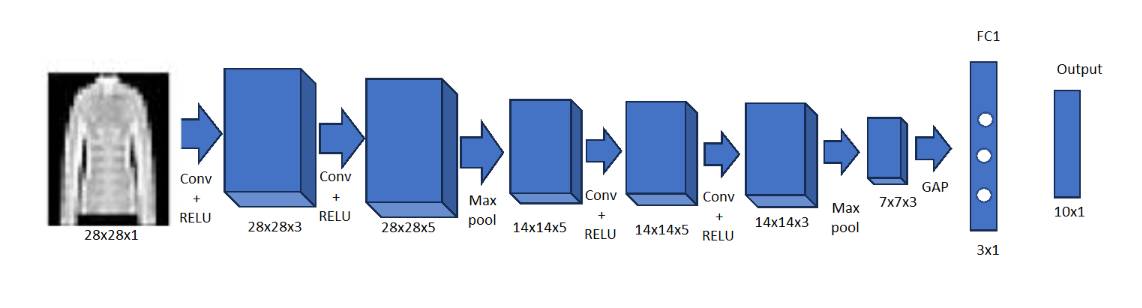

In [ ]:
# Get the class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Create and print the label dictionary
label_dict = {i: class_names[i] for i in range(len(class_names))}
print(label_dict)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


In [ ]:
def LABEL_MAP(index: int) -> str:
  """Maps every index number representing a class in the Fashion MNIST dataset to the name of the class(i.e string)"""
  label_map: dict = {
      0: "T-shirt/top",
      1: "Trouser",
      2: "Pullover",
      3: "Dress",
      4: "Coat",
      5: "Sandal",
      6: "Shirt",
      7: "Sneaker",
      8: "Bag",
      9: "Ankle boot"
  }

  try:
    return label_map[index]
  except KeyError:
    raise KeyError("{} does not represent a valid class!".format(index)) from None


In [ ]:

import torch
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, random_split

# Transformations: Convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the dataset
train_dataset = FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root="./data", train=False, download=True, transform=transform)

# Split train_dataset into 80% train and 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

# Display dataset sizes
print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_dataset)}")

# Create DataLoaders
batch_size = 1024  # Use best batch size from Assignment 3
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 26.4M/26.4M [00:03<00:00, 8.64MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 132kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 2.41MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 18.2MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train set size: 48000
Validation set size: 12000
Test set size: 10000


In [ ]:

import torch.nn as nn
import torch.nn.functional as F
import torch

# Define the CNN architecture
class CAM_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CAM_CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3, padding=1)  # Input: 28x28x1, Output: 28x28x3
        self.conv2 = nn.Conv2d(3, 5, kernel_size=3, padding=1)  # Input: 28x28x3, Output: 28x28x5
        self.pool1 = nn.MaxPool2d(2, 2)  # Output: 14x14x5

        self.conv3 = nn.Conv2d(5, 5, kernel_size=3, padding=1)  # Input: 14x14x5, Output: 14x14x5
        self.conv4 = nn.Conv2d(5, 3, kernel_size=3, padding=1)  # Input: 14x14x5, Output: 14x14x3
        self.pool2 = nn.MaxPool2d(2, 2)  # Output: 7x7x3

        self.feature_maps = None
        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Output: 3x1x1

        # Fully Connected Layer
        self.fc = nn.Linear(3, num_classes)  # GAP Output flattened to 3 -> Output: 10

        # Xavier initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # Forward pass through CNN
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        self.feature_maps = x  # Save feature maps before GAP
        # Global Average Pooling
        x = self.gap(x)  # Output: 3x1x1
        x = x.view(x.size(0), -1)  # Flatten GAP output to 3

        # Fully Connected Layer
        x = self.fc(x)  # Output: 10 (logits)
        return x




Epoch 1/20, Training Loss: 2.2967, Validation Loss: 2.2836
Epoch 2/20, Training Loss: 2.2479, Validation Loss: 2.1979
Epoch 3/20, Training Loss: 2.0994, Validation Loss: 1.9809
Epoch 4/20, Training Loss: 1.8678, Validation Loss: 1.7732
Epoch 5/20, Training Loss: 1.7022, Validation Loss: 1.6418
Epoch 6/20, Training Loss: 1.5926, Validation Loss: 1.5492
Epoch 7/20, Training Loss: 1.5104, Validation Loss: 1.4763
Epoch 8/20, Training Loss: 1.4434, Validation Loss: 1.4107
Epoch 9/20, Training Loss: 1.3877, Validation Loss: 1.3596
Epoch 10/20, Training Loss: 1.3393, Validation Loss: 1.3130
Epoch 11/20, Training Loss: 1.2926, Validation Loss: 1.2687
Epoch 12/20, Training Loss: 1.2450, Validation Loss: 1.2134
Epoch 13/20, Training Loss: 1.1949, Validation Loss: 1.1666
Epoch 14/20, Training Loss: 1.1411, Validation Loss: 1.1061
Epoch 15/20, Training Loss: 1.0854, Validation Loss: 1.0567
Epoch 16/20, Training Loss: 1.0364, Validation Loss: 1.0155
Epoch 17/20, Training Loss: 1.0006, Validation Lo

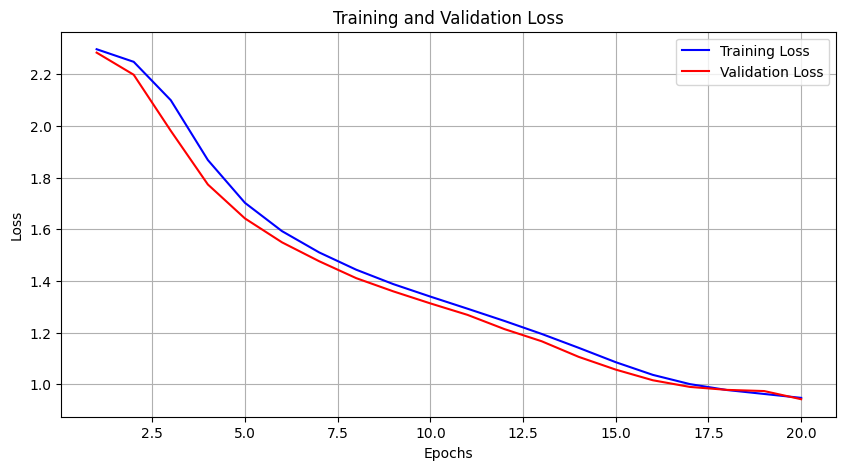

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
learning_rate = 0.001
batch_size = 1024
num_epochs = 20    #needs more epoches, 10 as its faster rn

# Data preparation (splits already created)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = CAM_CNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training loop
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()  # Set model to evaluation mode, this prevents batch norm and dropout but in this case we havent used it
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


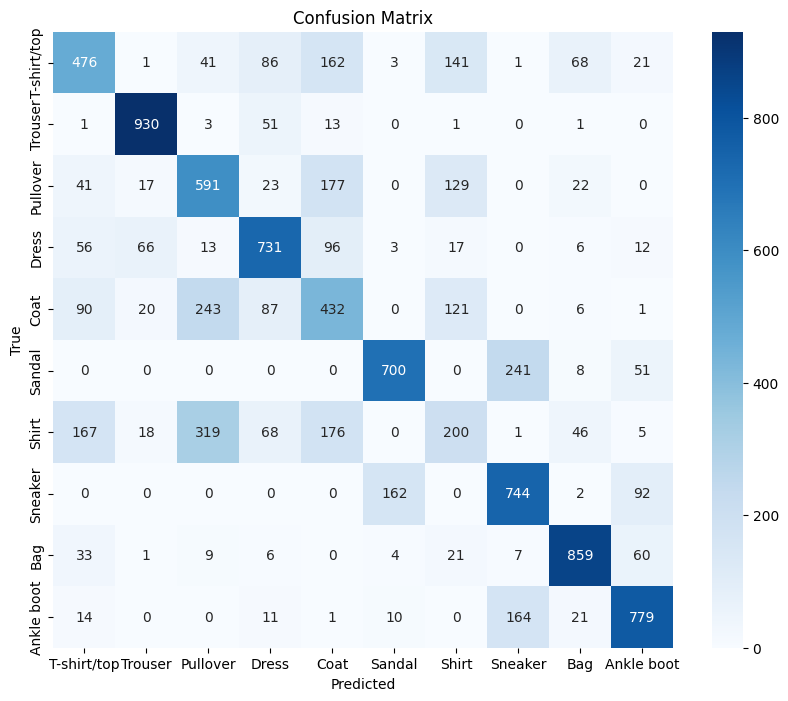

Classification Report:

              precision    recall  f1-score   support

 T-shirt/top       0.54      0.48      0.51      1000
     Trouser       0.88      0.93      0.91      1000
    Pullover       0.48      0.59      0.53      1000
       Dress       0.69      0.73      0.71      1000
        Coat       0.41      0.43      0.42      1000
      Sandal       0.79      0.70      0.74      1000
       Shirt       0.32      0.20      0.25      1000
     Sneaker       0.64      0.74      0.69      1000
         Bag       0.83      0.86      0.84      1000
  Ankle boot       0.76      0.78      0.77      1000

    accuracy                           0.64     10000
   macro avg       0.63      0.64      0.64     10000
weighted avg       0.63      0.64      0.64     10000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Evaluation on test data
model.eval()  # Set the model to evaluation mode
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        prob_scores = probs.squeeze().cpu().numpy()  # Get all class probabilities
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.classes  # Assuming your dataset is loaded as torchvision dataset

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))


In [ ]:
import cv2
def generate_cam(feature_maps, weights, class_idx):
    """
    Generate the Class Activation Map (CAM).

    Args:
        feature_maps (Tensor): The feature maps from the last convolutional layer (shape: [C, H, W]).
        weights (Tensor): The weights of the FC layer corresponding to the class.
        class_idx (int): The class index for which to generate the CAM.

    Returns:
        cam (ndarray): The Class Activation Map, resized to match the original image size.
    """
    # Multiply each feature map by the corresponding weight and sum them up
    cam = torch.sum(feature_maps * weights[class_idx].unsqueeze(-1).unsqueeze(-1), dim=0).cpu().numpy()

    # Normalize the CAM to [0, 1]
    cam -= cam.min()
    cam /= cam.max()

    cam_resized = cv2.resize(cam, (28, 28), interpolation=cv2.INTER_CUBIC)

    return cam_resized

In [ ]:
def visualize_correct_predictions(model, test_loader, class_names, num_samples=10):
    model.eval()
    correct_count = 0
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for idx in range(images.size(0)):
                if preds[idx] == labels[idx]:  # Correct predictions
                    feature_maps = model.feature_maps[idx]
                    fc_weights = model.fc.weight.data

                    cam = generate_cam(feature_maps, fc_weights, class_idx=labels[idx].item())
                    cam_probability = F.softmax(outputs, dim=1)[idx, preds[idx]].item()

                    # Display the image and CAM
                    axes[correct_count, 0].imshow(images[idx].cpu().squeeze(), cmap="gray")
                    axes[correct_count, 0].set_title(f"Input Image\nClass: {class_names[labels[idx]]}")
                    axes[correct_count, 1].imshow(images[idx].cpu().squeeze(), cmap="gray")
                    axes[correct_count, 1].imshow(cam, cmap="jet", alpha=0.5)
                    axes[correct_count, 1].set_title(f"CAM Overlay\nClass: {class_names[labels[idx]]}\nProbability: {cam_probability:.2f}")

                    correct_count += 1
                    if correct_count >= num_samples:
                        plt.tight_layout()
                        plt.show()
                        return


In [ ]:
def visualize_incorrect_predictions(model, test_loader, class_names, num_samples=30):
    model.eval()
    incorrect_count = 0
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 3))

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) #as logits
            _, preds = torch.max(outputs, 1) #converts highest logit to 1, is prediction.

            for idx in range(images.size(0)):
                if preds[idx] != labels[idx]:  # Incorrect predictions
                    feature_maps = model.feature_maps[idx]
                    fc_weights = model.fc.weight.data

                    # Generate CAMs for ground truth and predicted classes
                    cam_truth = generate_cam(feature_maps, fc_weights, class_idx=labels[idx].item())
                    cam_pred = generate_cam(feature_maps, fc_weights, class_idx=preds[idx].item())
                    cam_probability = F.softmax(outputs, dim=1)[idx, preds[idx]].item() #converts logits to probability

                    # Display the image and CAMs
                    axes[incorrect_count, 0].imshow(images[idx].cpu().squeeze(), cmap="gray")
                    axes[incorrect_count, 0].set_title(f"Input Image\nClass: {class_names[labels[idx]]}")
                    axes[incorrect_count, 1].imshow(images[idx].cpu().squeeze(), cmap="gray")
                    axes[incorrect_count, 1].imshow(cam_truth, cmap="jet", alpha=0.5)
                    axes[incorrect_count, 1].set_title(f"CAM Truth\nClass: {class_names[labels[idx]]}")
                    axes[incorrect_count, 2].imshow(images[idx].cpu().squeeze(), cmap="gray")
                    axes[incorrect_count, 2].imshow(cam_pred, cmap="jet", alpha=0.5)
                    axes[incorrect_count, 2].set_title(f"CAM Pred\nClass: {class_names[preds[idx]]}\nProbability: {cam_probability:.2f}")

                    incorrect_count += 1
                    if incorrect_count >= num_samples:
                        plt.tight_layout()
                        plt.show()
                        return


Visualizing Correct Predictions:


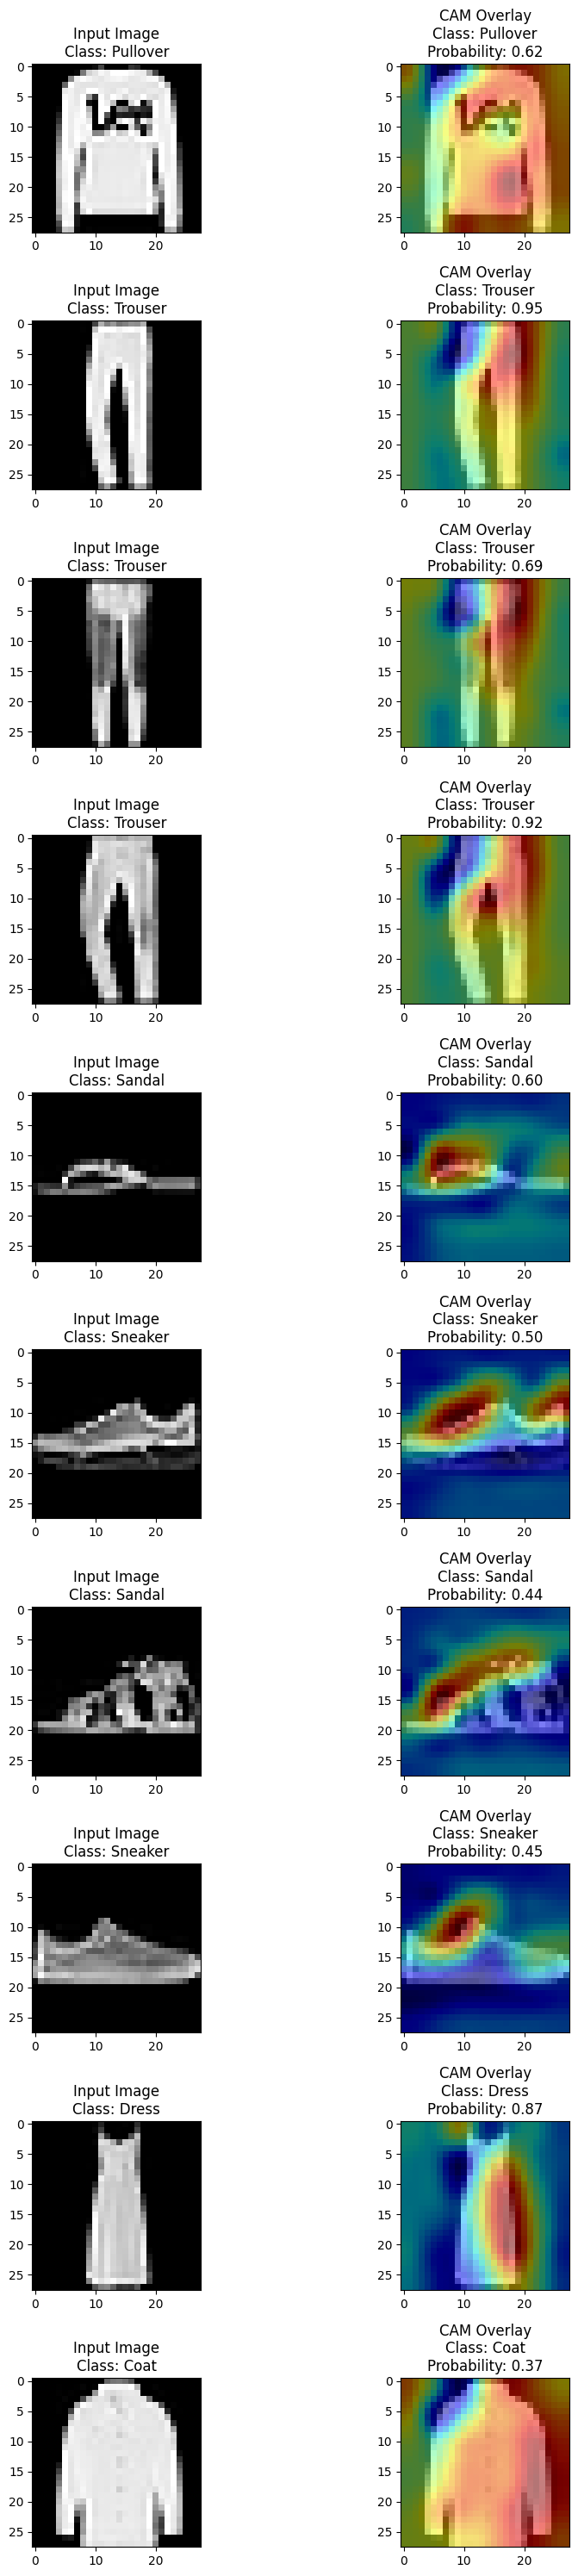

Visualizing Incorrect Predictions:


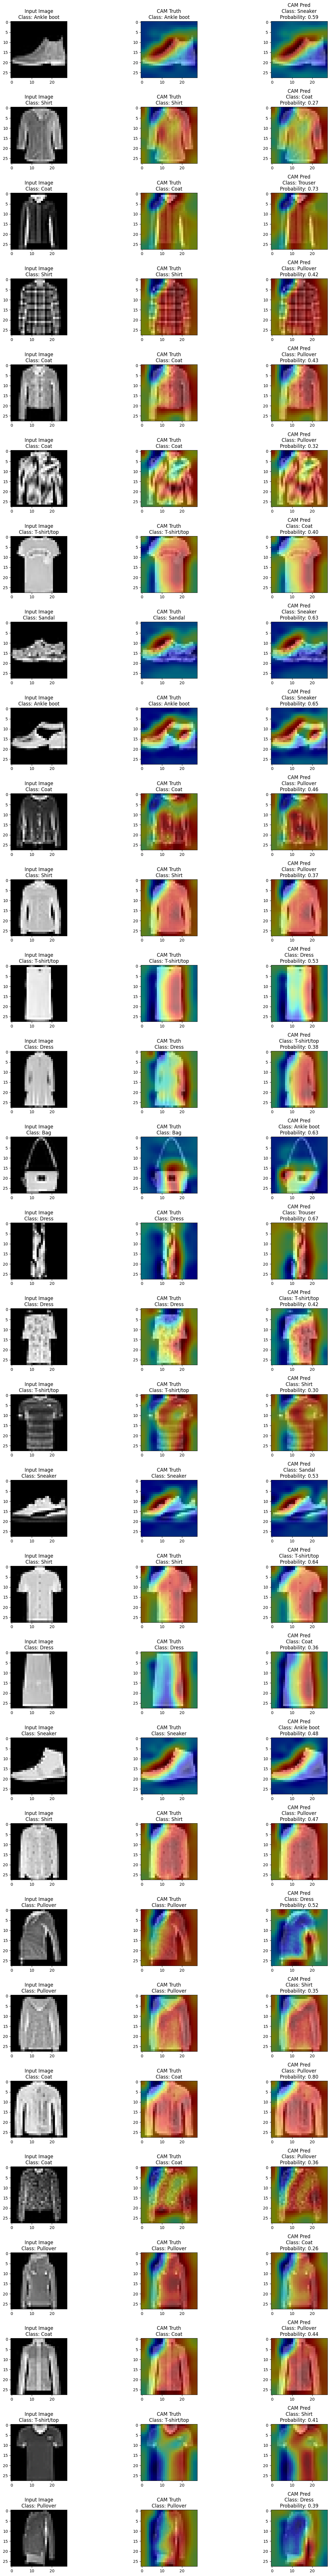

In [ ]:


# Call the function
print("Visualizing Correct Predictions:")
visualize_correct_predictions(model, test_loader, class_names)


print("Visualizing Incorrect Predictions:")
visualize_incorrect_predictions(model, test_loader, class_names)


## Assignment 4B (Learn to pay attention) -- 25% marks

#### Problem Statement

1. Use MNIST Fashion dataset

2. Use the following architecture to force your model to pay attention in the interesting area so that the classification is more correct.

3. Train with your train data. Plot training loss, validation loss for learning rate 0.001 and batch size: 1024/2048 (Which one was best from assignment 3).

4. Run the test on the test split and report confusion matrix and the F1 scores for your test data. Compare your performance with assignment 3

5. Now pick 10 test data (where predictions are right) from 10 classes, pass them through the trained network, produce attention maps for the input images. Show the input images and attention maps with ground truth class name, predicted class name, and probability scores (as shown in page 9 of lecture 5.2).

6. Now randomly pick 30 test data (where prediction were wrong) from 10 classes, pass them through the trained network, produce attention map for the input images. Show the input images and attention maps (for ground truth class and for predicted class ) with ground truth class name, predicted class name, and probability scores (as shown in page 9 of lecture 5.2)

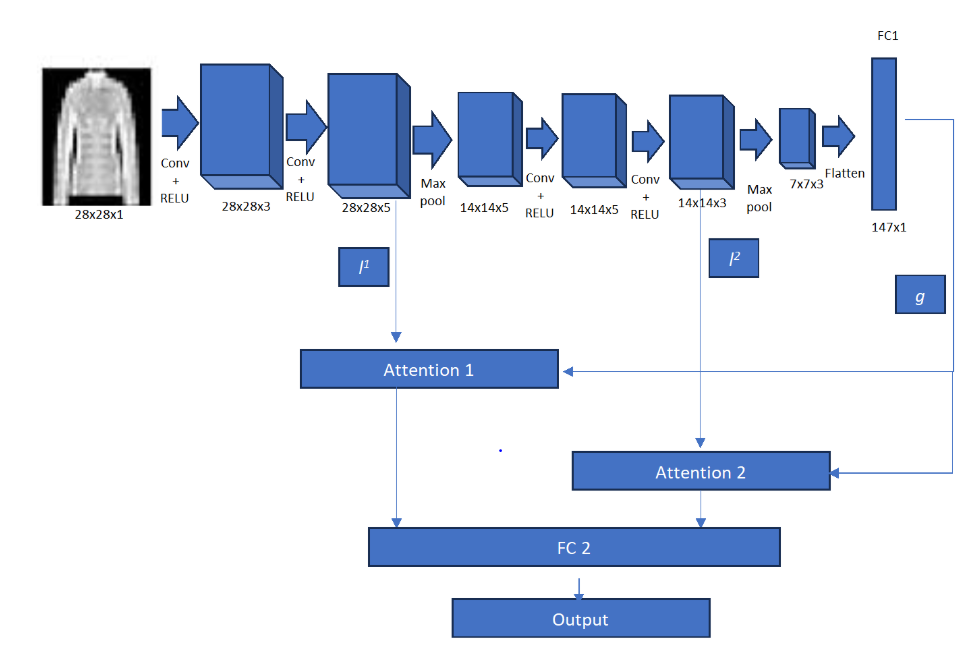

In [ ]:
import torch
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms


# Transformations: Convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the dataset
train_dataset = FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root="./data", train=False, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.5MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 332kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.42MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.77MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:

import torch
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, random_split


# Split train_dataset into 80% train and 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

# Display dataset sizes
print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_dataset)}")

# Create DataLoaders
batch_size = 1024  # Use best batch size from Assignment 3
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Train set size: 48000
Validation set size: 12000
Test set size: 10000


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy



class AttentionCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AttentionCNN, self).__init__()
        # Feature extraction layers
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3, padding=1)  # 28x28x1 -> 28x28x3
        self.conv2 = nn.Conv2d(3, 5, kernel_size=3, padding=1)  # 28x28x3 -> 28x28x5
        self.pool1 = nn.MaxPool2d(2, 2)                        # 28x28x5 -> 14x14x5

        self.conv3 = nn.Conv2d(5, 5, kernel_size=3, padding=1)  # 14x14x5 -> 14x14x5
        self.conv4 = nn.Conv2d(5, 3, kernel_size=3, padding=1)  # 14x14x5 -> 14x14x3
        self.pool2 = nn.MaxPool2d(2, 2)                        # 14x14x3 -> 7x7x3

        self.mapOne1 = nn.Linear(784, 147)
        self.mapOne2 = nn.Linear(784, 147)
        self.mapOne3 = nn.Linear(784, 147)
        self.mapOne4 = nn.Linear(784, 147)
        self.mapOne5 = nn.Linear(784, 147)

        self.mapTwo1 = nn.Linear(196, 147)
        self.mapTwo2 = nn.Linear(196, 147)
        self.mapTwo3 = nn.Linear(196, 147)


        # Dropouts on the fully connected layers
        self.dropout = nn.Dropout(0.5)

        # Fully connected layers
        self.flatten = nn.Flatten()  # 7x7x3 -> 147x1
        self.fc1 = nn.Linear(147, 147)  # New fully connected layer
        self.fc2 = nn.Linear( 1176, num_classes)


    def forward(self, x):
        # Feature extraction
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        l1 = x  # Save l^1 size: #B X 5 X 28 X 28
        l1_copy = x
        l1 = l1.reshape(l1.shape[0], l1.shape[1], -1) # B x 5 x 784

        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        l2 = x  # Save l^2  #B X 3 X 14 X 14
        l2_copy = x
        l2 = l2.reshape(l2.shape[0], l2.shape[1], -1) # B x 3 x 196

        x = self.pool2(x) #B x 3 x 7 x 7
        x = self.flatten(x) # B x 147

        # Fully connected layers
        g = F.relu(self.fc1(x))
        g1 = g.unsqueeze(-1)  # B x 147 x 1
        g2 = g.unsqueeze(-1)  # B x 147 x 1

        # attention calculation

        #here we create 5 diff projections from the 5 channels
        projOne1 = self.mapOne1(l1[:, 0, :]).unsqueeze(1) # B x 1 x 147
        projOne2 = self.mapOne2(l1[:, 1, :]).unsqueeze(1)
        projOne3 = self.mapOne3(l1[:, 2, :]).unsqueeze(1)
        projOne4 = self.mapOne4(l1[:, 3, :]).unsqueeze(1)
        projOne5 = self.mapOne5(l1[:, 4, :]).unsqueeze(1)
        #print(projOne1.shape)

        aOne1 = F.softmax(torch.matmul(projOne1, g1), dim=1) #B X 1 X  1
        aOne2 = F.softmax(torch.matmul(projOne2, g1), dim=1)
        aOne3 = F.softmax(torch.matmul(projOne3, g1), dim=1)
        aOne4 = F.softmax(torch.matmul(projOne4, g1), dim=1)
        aOne5 = F.softmax(torch.matmul(projOne5, g1), dim=1)
        #print(aOne1.shape)

        g_aOne1 = (aOne1*projOne1).squeeze(1) #B x 147
        g_aOne2 = (aOne2*projOne2).squeeze(1)
        g_aOne3 = (aOne3*projOne3).squeeze(1)
        g_aOne4 = (aOne4*projOne4).squeeze(1)
        g_aOne5 = (aOne5*projOne5).squeeze(1)
        #print(g_aOne1.shape)

        g_aOne = torch.cat([g_aOne1, g_aOne2, g_aOne3, g_aOne4, g_aOne5], dim=1)
        #print(g_aOne.shape) #B X 5 X 147

        #attention1 map
              # Calculate weighted channels for attention1
        weighted_channel1 = aOne1 * l1_copy[:, 0, :]  # B x 784
        weighted_channel2 = aOne2 * l1_copy[:, 1, :]
        weighted_channel3 = aOne3 * l1_copy[:, 2, :]
        weighted_channel4 = aOne4 * l1_copy[:, 3, :]
        weighted_channel5 = aOne5 * l1_copy[:, 4, :]

        # Stack all the weighted channels (B x 5 x 28 X 28)
        weighted_channels = torch.stack([weighted_channel1, weighted_channel2, weighted_channel3, weighted_channel4, weighted_channel5], dim=1)
        #print(weighted_channels.shape)

        # Average across the channel axis (B X 28 X 28)
        attention_map1 = weighted_channels.mean(dim=1)
        #print(attention_map1.shape)


        #attention 2

        projTwo1 = self.mapTwo1(l2[:, 0, :]).unsqueeze(1) #B X 1 X 147
        projTwo2 = self.mapTwo2(l2[:, 1, :]).unsqueeze(1) #B X 1 X 147
        projTwo3 = self.mapTwo3(l2[:, 2, :]).unsqueeze(1) #B X 1 X 147

        aTwo1 = F.softmax(torch.matmul(projTwo1, g1), dim=1)
        aTwo2 = F.softmax(torch.matmul(projTwo2, g1), dim=1)
        aTwo3 = F.softmax(torch.matmul(projTwo3, g1), dim=1)
        #print(aTwo1.shape) #B X 1 X 1

        g_aTwo1 = (aTwo1*projTwo1).squeeze(1)
        g_aTwo2 = (aTwo2*projTwo2).squeeze(1)
        g_aTwo3 = (aTwo3*projTwo3).squeeze(1)
        g_aTwo = torch.cat([g_aTwo1, g_aTwo2, g_aTwo3], dim=1)
        #print(g_aTwo.shape) #B X 3 X 147

        x = torch.cat([g_aOne, g_aTwo], dim=1)
        #print(x.shape) # B X 8 X 147
        x.flatten(1)

        #To create HEATMAP2
        # Calculate softmax weighted channels for attention2
        weighted_channel2_1 = aTwo1 * l2_copy[:, 0, :]  # B x 196
        weighted_channel2_2 = aTwo2 * l2_copy[:, 1, :]
        weighted_channel2_3 = aTwo3 * l2_copy[:, 2, :]

        # Stack all the weighted channels (B x 3 x 196)
        weighted_channels2 = torch.stack([weighted_channel2_1, weighted_channel2_2, weighted_channel2_3], dim=1)

        # Average across the channel axis (B x 196), creating a single map for each sample
        attention_map2 = weighted_channels2.mean(dim=1)  # B x 196

        # Reshape into 14x14 for visualization (B x 14 x 14)
        attention_map2 = attention_map2.view(-1, 14, 14)  # B x 14 x 14


        # Final classification
        x = self.fc2(x)  # Output logits
        return x, attention_map1, attention_map2


In [ ]:
import torch.optim as optim

# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AttentionCNN(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, l1, l2 = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, l1, l2 = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(test_loader))
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")


Epoch 1, Train Loss: 1.1902892399341503, Validation Loss: 0.5911523699760437
Epoch 2, Train Loss: 0.4853131415996146, Validation Loss: 0.46877615749835966
Epoch 3, Train Loss: 0.41366376458330356, Validation Loss: 0.4320208042860031
Epoch 4, Train Loss: 0.38330319206765356, Validation Loss: 0.41098790168762206
Epoch 5, Train Loss: 0.3630695805904713, Validation Loss: 0.39720056653022767
Epoch 6, Train Loss: 0.346295638921413, Validation Loss: 0.39003010988235476
Epoch 7, Train Loss: 0.33521017685849613, Validation Loss: 0.37993837893009186
Epoch 8, Train Loss: 0.32052850786675796, Validation Loss: 0.37379845678806306
Epoch 9, Train Loss: 0.30718192965426344, Validation Loss: 0.3558963030576706
Epoch 10, Train Loss: 0.2999480480843402, Validation Loss: 0.3598722815513611


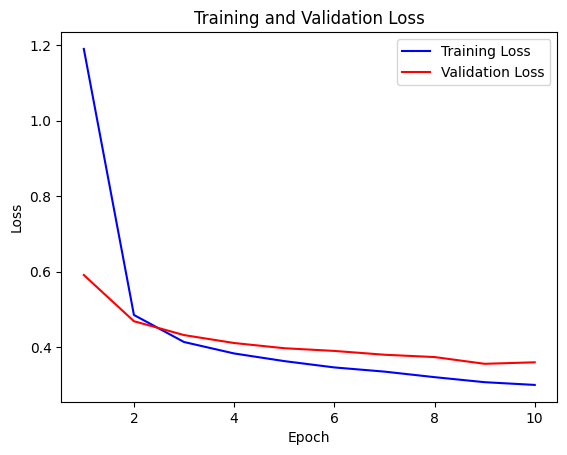

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation losses
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", color="blue")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

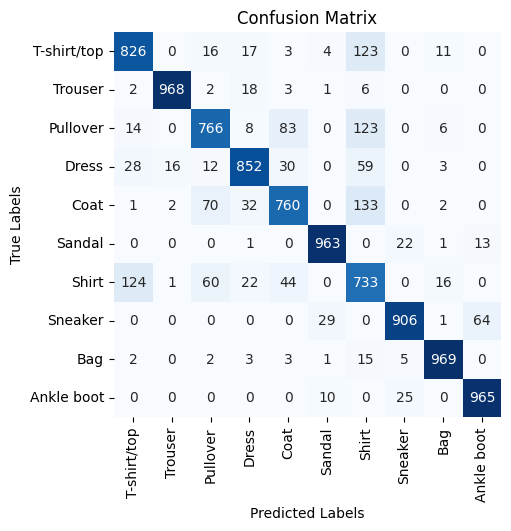

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1000
           1       0.98      0.97      0.97      1000
           2       0.83      0.77      0.79      1000
           3       0.89      0.85      0.87      1000
           4       0.82      0.76      0.79      1000
           5       0.96      0.96      0.96      1000
           6       0.61      0.73      0.67      1000
           7       0.95      0.91      0.93      1000
           8       0.96      0.97      0.96      1000
           9       0.93      0.96      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on test data
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, l1, l2 = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Seaborn heatmap for confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Classification report
report = classification_report(all_labels, all_preds)
print(f"Classification Report:\n{report}")

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def create_heatmaps(input_image, attention1, attention2):
    batch_size = input_image.size(0)

    for b in range(batch_size):
        # Get single input image
        img = input_image[b].squeeze().cpu().numpy()  # Shape: [28, 28]

        # Normalize Attention 1
        heatmap1 = attention1.cpu().numpy()  # Shape: [28, 28]
        heatmap1 -= heatmap1.min()
        if heatmap1.max() > 0:
            heatmap1 /= heatmap1.max()  # Normalize to [0, 1]

        # Ensure attention2[b] has the correct shape
        #print(f"Shape of attention2[{b}]: {attention2.shape}")  # Debugging the shape

        attention2_b = attention2.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, 28, 28]

        # Verify the shape after unsqueeze
        #print(f"Shape of attention2_b after unsqueeze: {attention2_b.shape}")  # Debugging the shape

        # Upsample and Normalize Attention 2

        heatmap2 = F.interpolate(attention2_b, size=(28, 28), mode="bilinear", align_corners=True).squeeze().cpu().numpy()  # Upsample to [28, 28]
        heatmap2 -= heatmap2.min()
        if heatmap2.max() > 0:
            heatmap2 /= heatmap2.max()  # Normalize to [0, 1]

        # Plot original image and heatmaps
        fig, axes = plt.subplots(1, 3, figsize=(9, 3))

        # Original Image
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title("Original Image")

        # Heatmap 1 (Attention 1)
        axes[1].imshow(img, cmap='gray')
        axes[1].imshow(heatmap1, cmap='jet', alpha=0.5)
        axes[1].set_title("Attention 1 Heatmap")

        # Heatmap 2 (Attention 2, upsampled)
        axes[2].imshow(img, cmap='gray')
        axes[2].imshow(heatmap2, cmap='jet', alpha=0.5)
        axes[2].set_title("Attention 2 Heatmap (Upsampled)")

        for ax in axes:
            ax.axis('off')

        plt.tight_layout()
        plt.show()


Visualizing Incorrect Predictions:


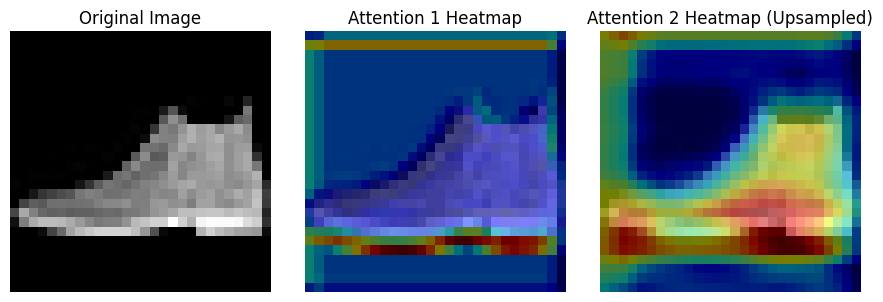

Ground Truth: Ankle boot, Predicted: Ankle boot, Probability: 0.9589214324951172


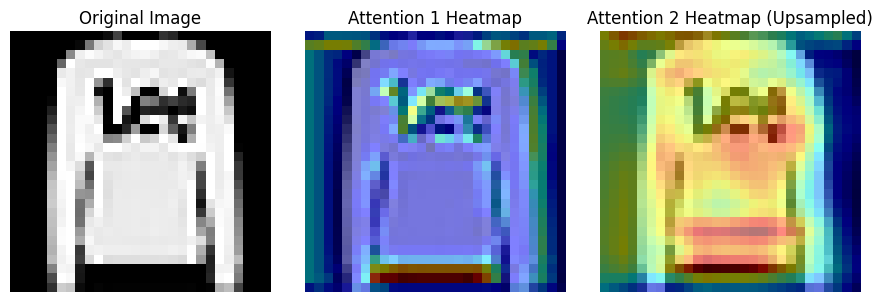

Ground Truth: Pullover, Predicted: Pullover, Probability: 0.9877929091453552


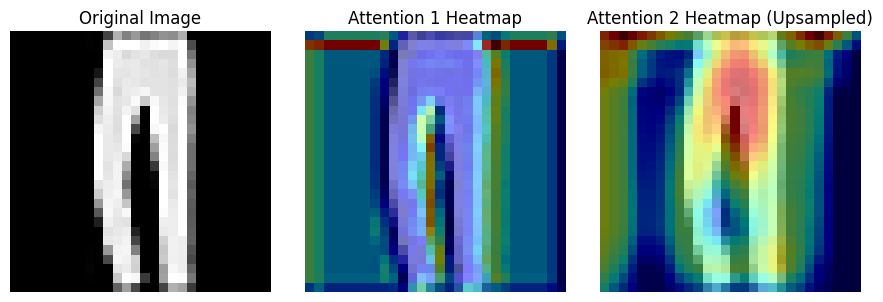

Ground Truth: Trouser, Predicted: Trouser, Probability: 0.9999785423278809


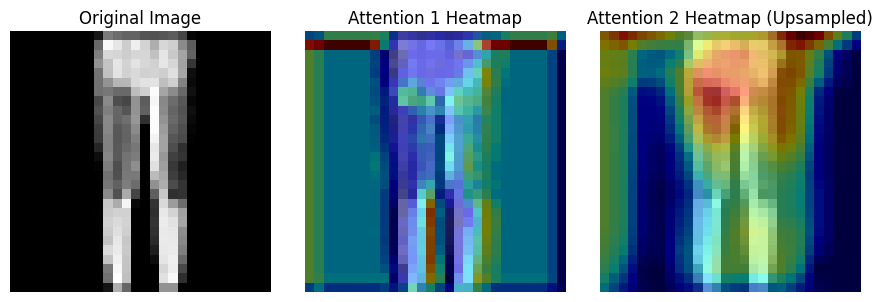

Ground Truth: Trouser, Predicted: Trouser, Probability: 0.9999768733978271


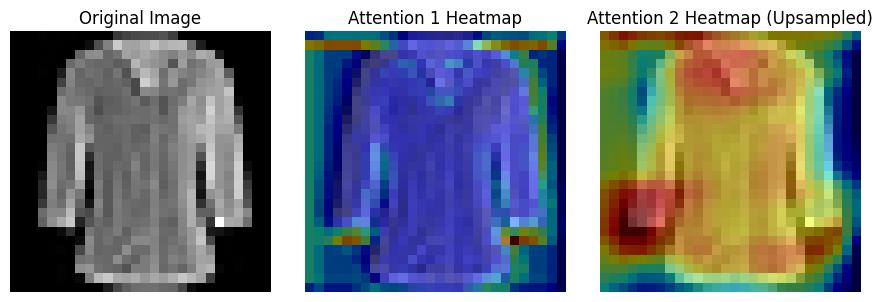

Ground Truth: Shirt, Predicted: Shirt, Probability: 0.9137125015258789


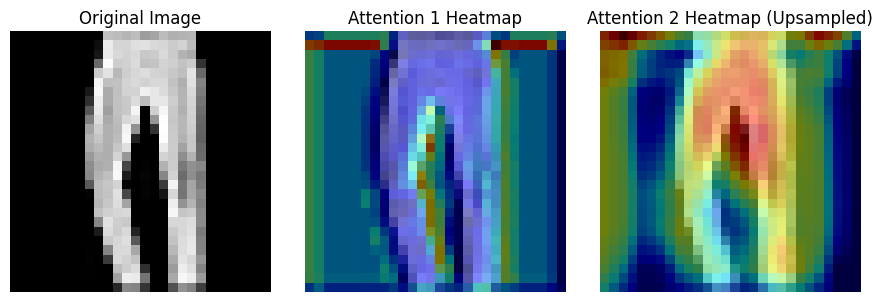

Ground Truth: Trouser, Predicted: Trouser, Probability: 0.9997913241386414


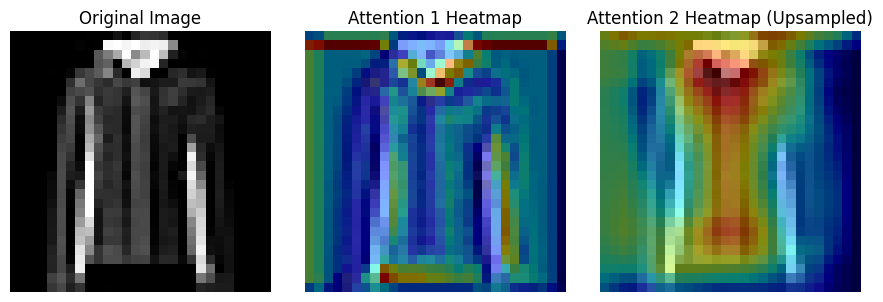

Ground Truth: Coat, Predicted: Coat, Probability: 0.9110408425331116


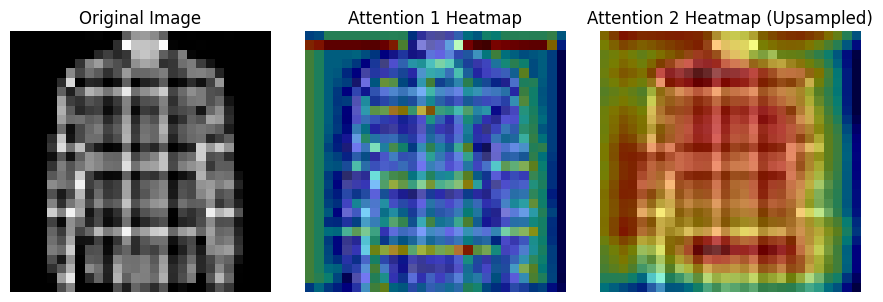

Ground Truth: Shirt, Predicted: Shirt, Probability: 0.9945557117462158


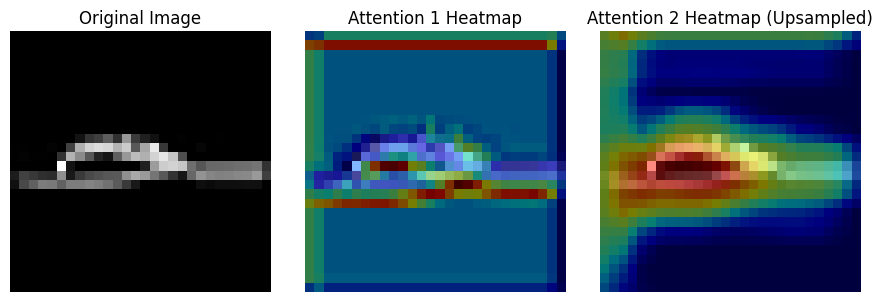

Ground Truth: Sandal, Predicted: Sandal, Probability: 0.9711336493492126


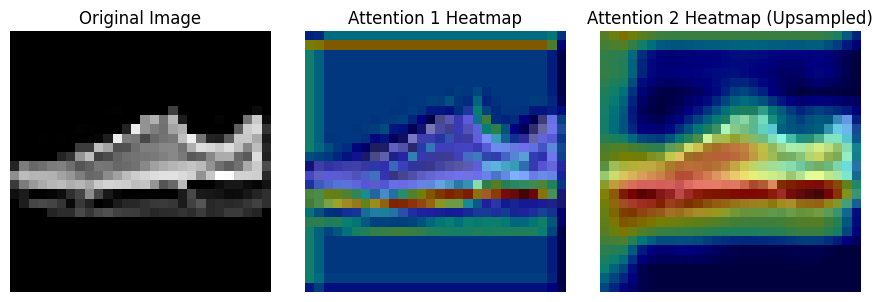

Ground Truth: Sneaker, Predicted: Sneaker, Probability: 0.997930645942688


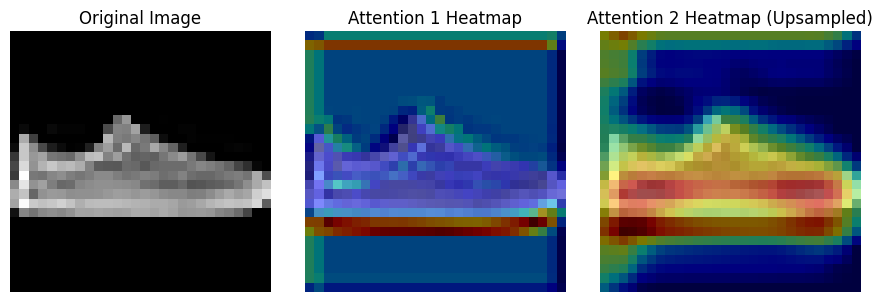

Ground Truth: Sneaker, Predicted: Sandal, Probability: 0.3977419435977936


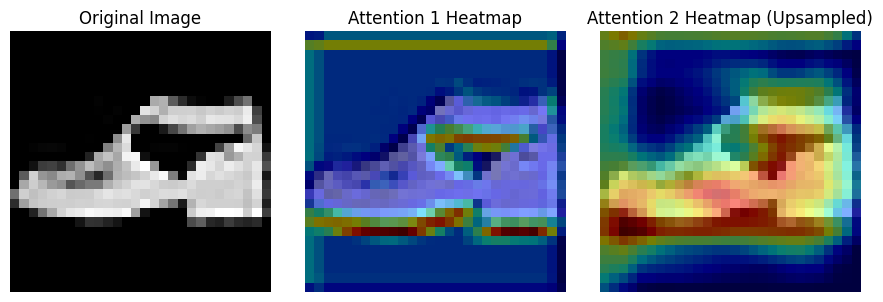

Ground Truth: Ankle boot, Predicted: Sandal, Probability: 0.9969593286514282


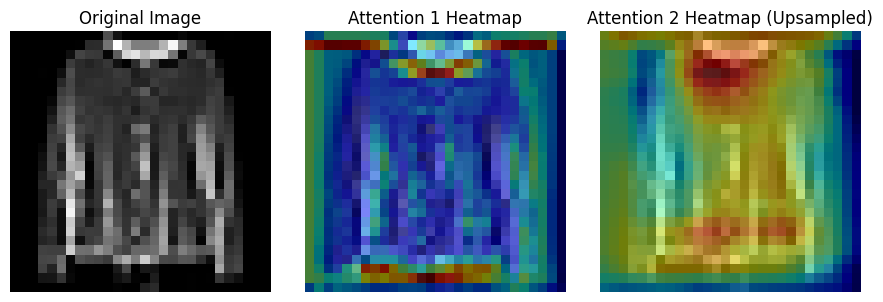

Ground Truth: Coat, Predicted: Shirt, Probability: 0.5677876472473145


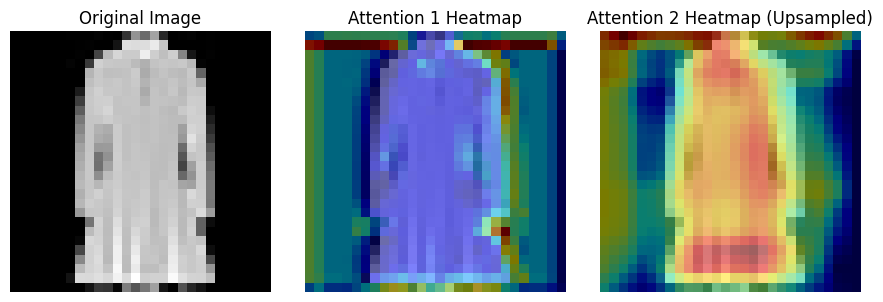

Ground Truth: Dress, Predicted: Shirt, Probability: 0.5034260153770447


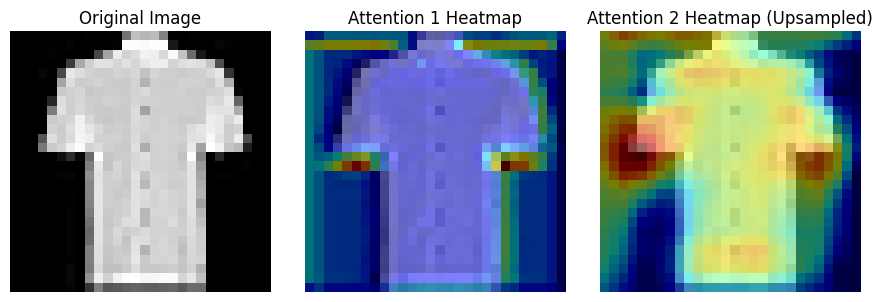

Ground Truth: Shirt, Predicted: T-shirt/top, Probability: 0.6162392497062683


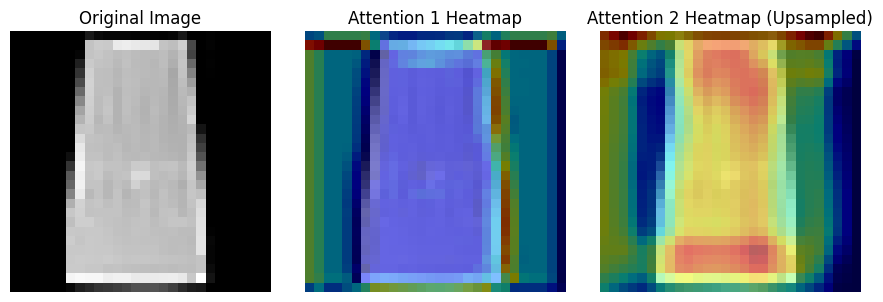

Ground Truth: Dress, Predicted: T-shirt/top, Probability: 0.2888442873954773


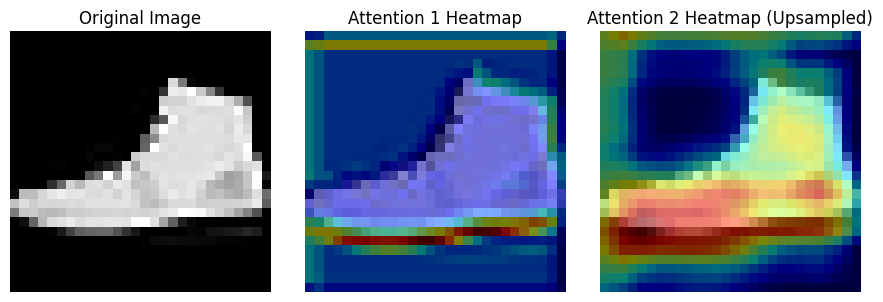

Ground Truth: Sneaker, Predicted: Ankle boot, Probability: 0.5526862144470215


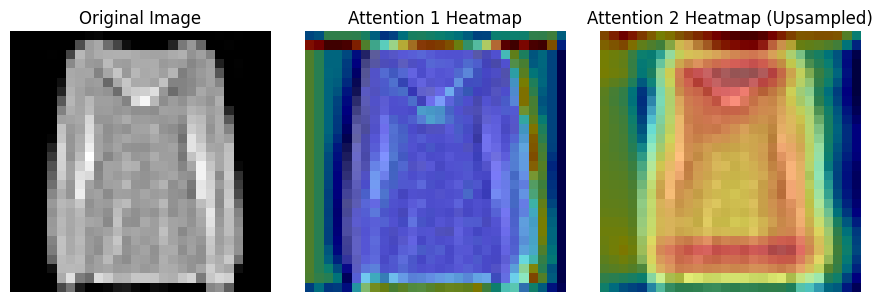

Ground Truth: Pullover, Predicted: Shirt, Probability: 0.8864129781723022


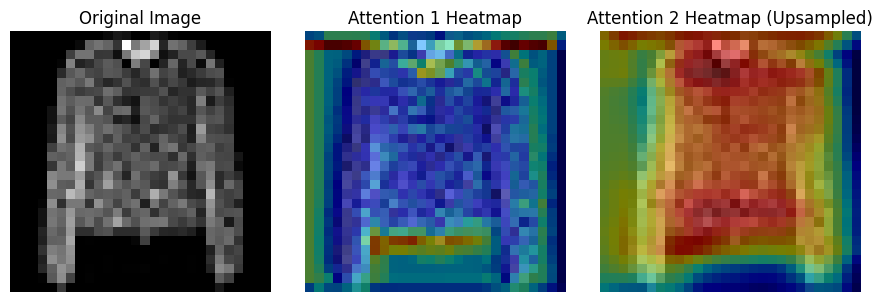

Ground Truth: Coat, Predicted: Shirt, Probability: 0.49336761236190796


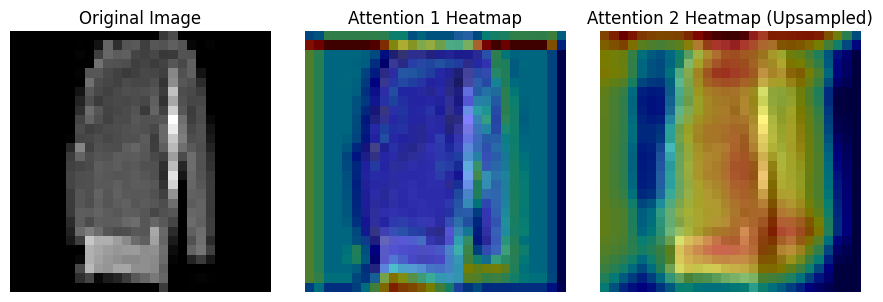

Ground Truth: Pullover, Predicted: Dress, Probability: 0.3911212086677551


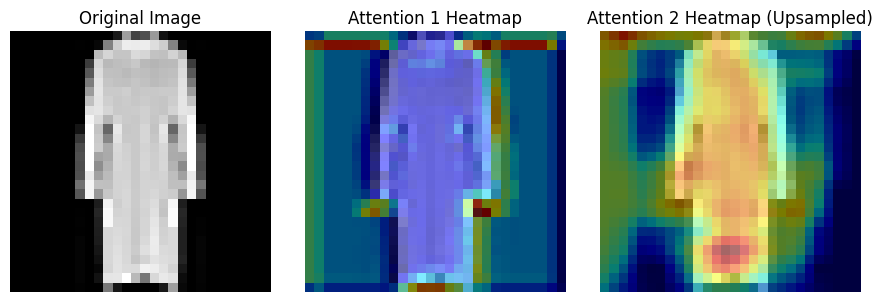

Ground Truth: Dress, Predicted: Coat, Probability: 0.5562063455581665


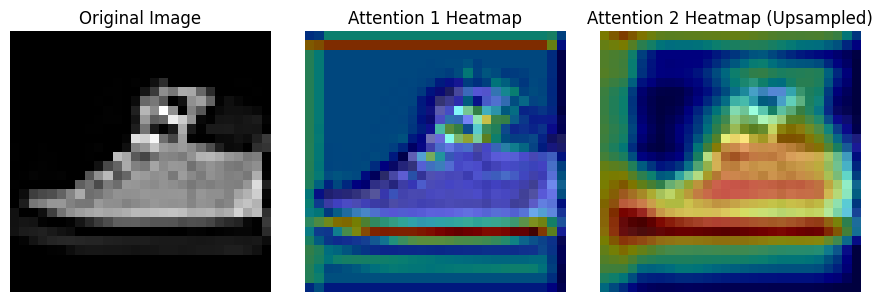

Ground Truth: Ankle boot, Predicted: Sneaker, Probability: 0.939667820930481


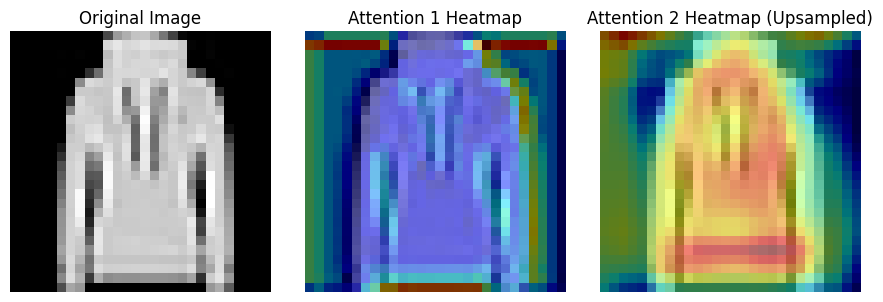

Ground Truth: Pullover, Predicted: Coat, Probability: 0.5535716414451599


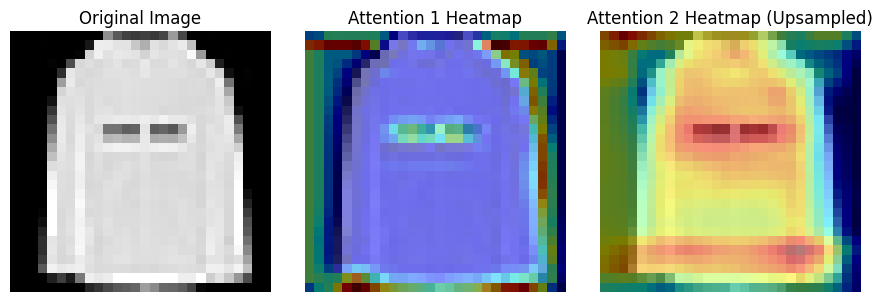

Ground Truth: Coat, Predicted: Pullover, Probability: 0.35010072588920593


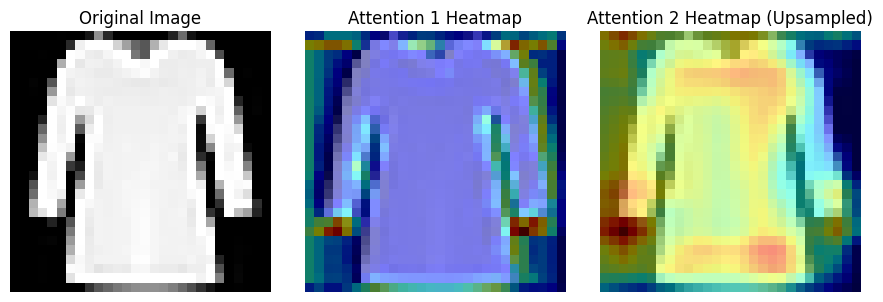

Ground Truth: T-shirt/top, Predicted: Shirt, Probability: 0.4363352358341217


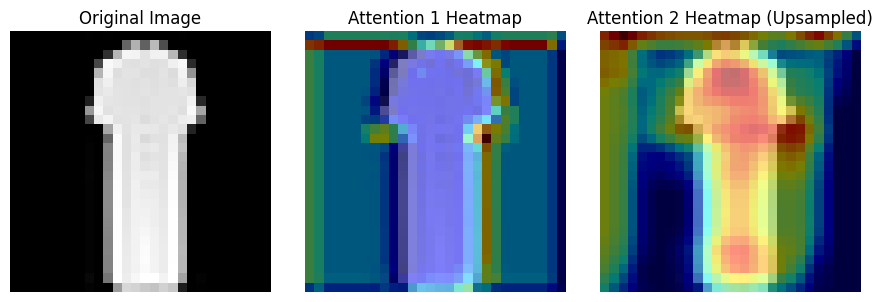

Ground Truth: Shirt, Predicted: Dress, Probability: 0.9102040529251099


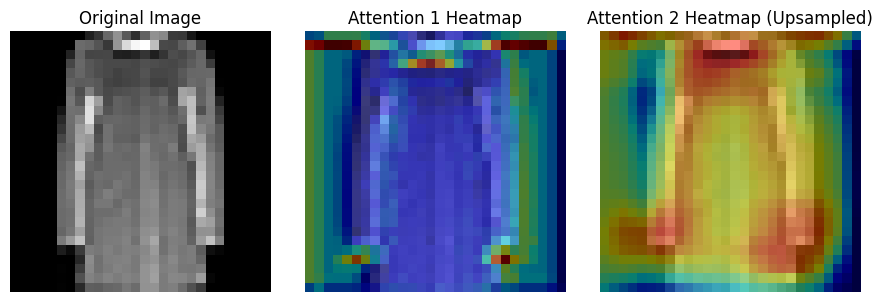

Ground Truth: Coat, Predicted: Dress, Probability: 0.40801337361335754


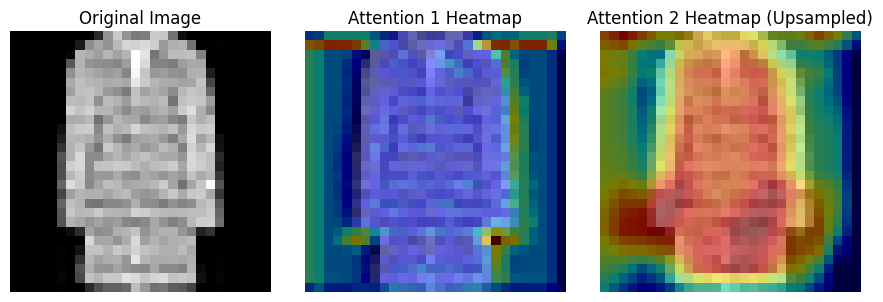

Ground Truth: Coat, Predicted: Dress, Probability: 0.7893232703208923


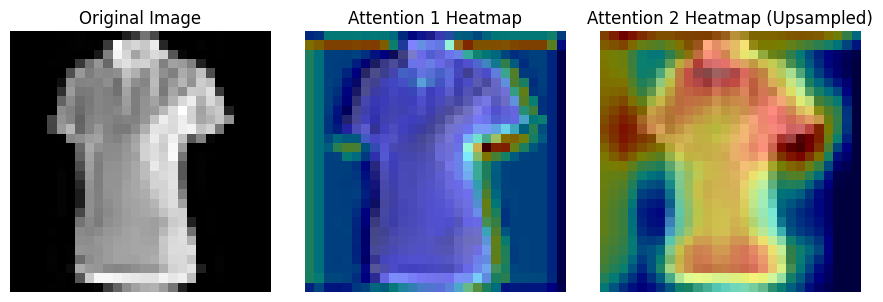

Ground Truth: T-shirt/top, Predicted: Shirt, Probability: 0.5415934920310974


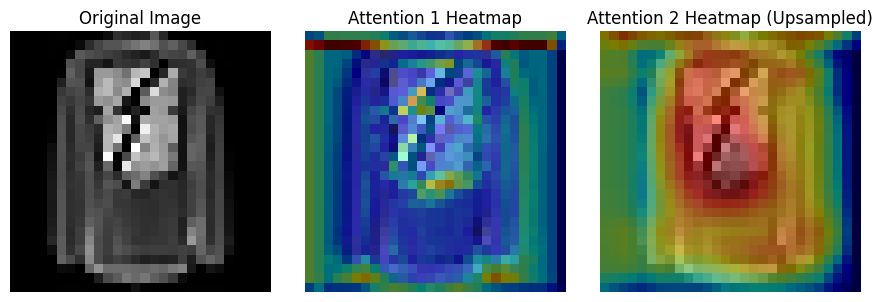

Ground Truth: Pullover, Predicted: Shirt, Probability: 0.4573412537574768


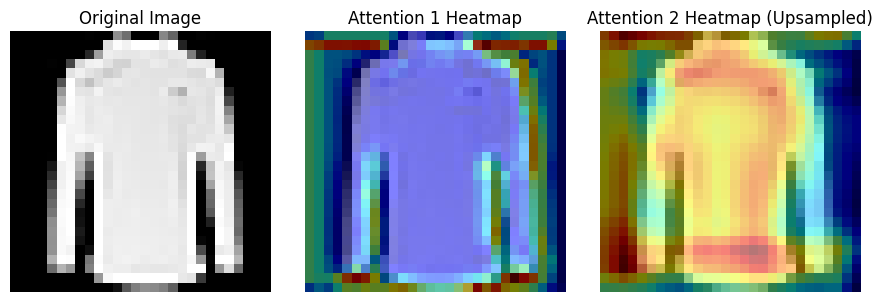

Ground Truth: Pullover, Predicted: Shirt, Probability: 0.6701323986053467


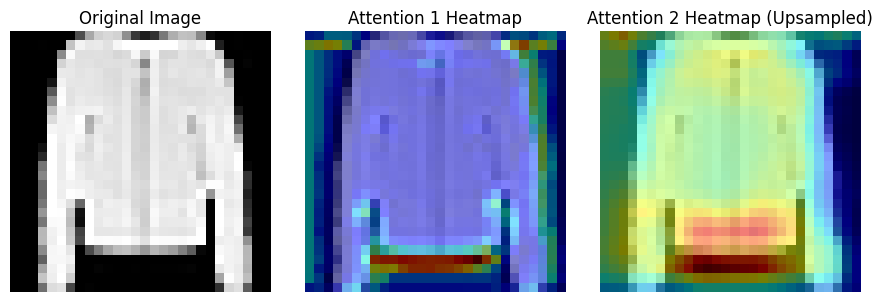

Ground Truth: Coat, Predicted: Pullover, Probability: 0.8097949624061584


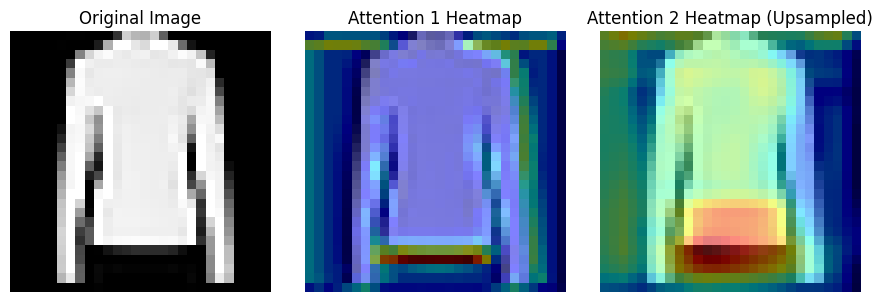

Ground Truth: Shirt, Predicted: Pullover, Probability: 0.5626934766769409


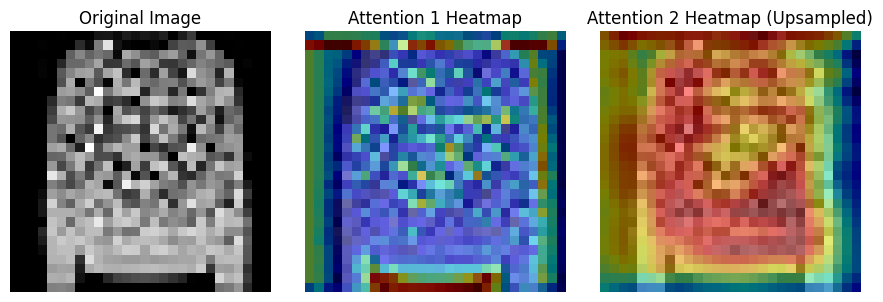

Ground Truth: Pullover, Predicted: Shirt, Probability: 0.9238882660865784


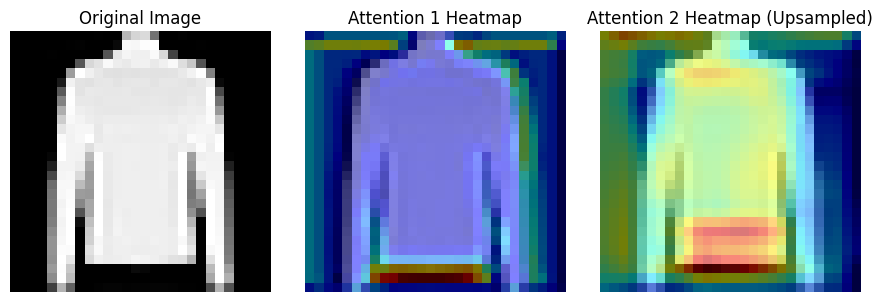

Ground Truth: Pullover, Predicted: Shirt, Probability: 0.5306736826896667


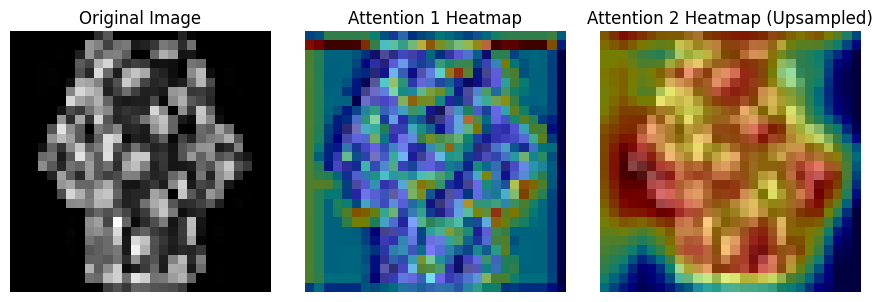

Ground Truth: Dress, Predicted: Shirt, Probability: 0.6066483855247498


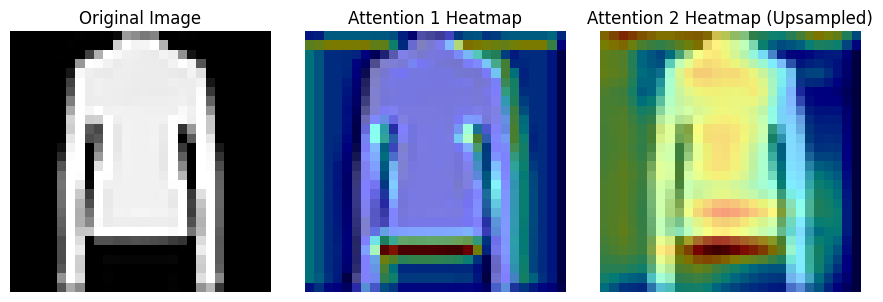

Ground Truth: Pullover, Predicted: Shirt, Probability: 0.42233309149742126


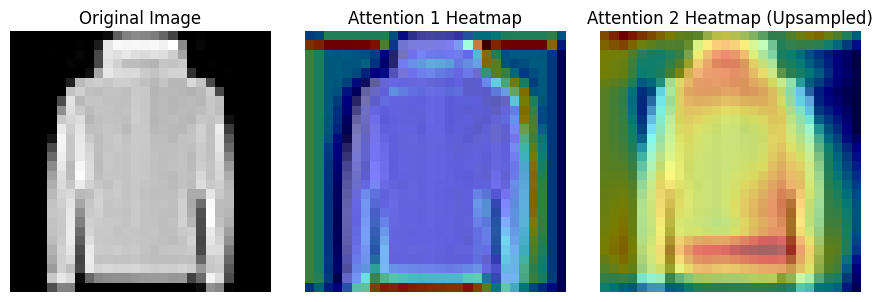

Ground Truth: Coat, Predicted: Pullover, Probability: 0.6430700421333313


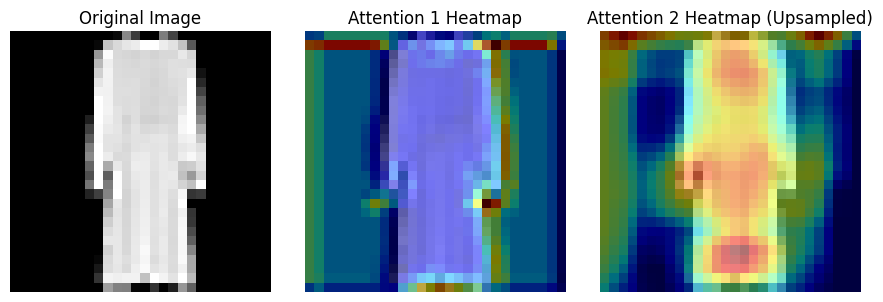

Ground Truth: Dress, Predicted: Coat, Probability: 0.5179943442344666


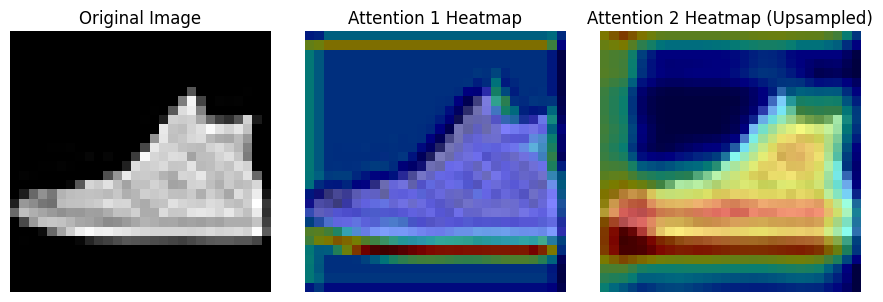

Ground Truth: Sneaker, Predicted: Ankle boot, Probability: 0.5082570910453796


In [ ]:


# Visualize correctly classified samples
def visualize_correct_predictions(model, test_loader, num_samples=30, label_dict=label_dict):
    model.eval()
    count = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, attention1, attention2 = model(inputs)
            prob = F.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            for i in range(inputs.size(0)):
                if preds[i] == labels[i] and count < num_samples:
                    # Incorrect prediction
                    #print(attention1.shape, attention2.shape)
                    create_heatmaps(inputs[i], attention1[i], attention2[i])
                    print(f"Ground Truth: {label_dict[labels[i].item()]}, Predicted: {label_dict[preds[i].item()]}, Probability: {prob[i][preds[i]].item()}")
                    count += 1
                if count >= num_samples:
                    return

# Visualize incorrectly classified samples
def visualize_incorrect_predictions(model, test_loader, num_samples=30, label_dict=label_dict):
    model.eval()
    count = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, attention1, attention2 = model(inputs)
            prob = F.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            for i in range(inputs.size(0)):
                if preds[i] != labels[i] and count < num_samples:
                    # Incorrect prediction
                    #print(attention1.shape, attention2.shape)
                    create_heatmaps(inputs[i], attention1[i], attention2[i])
                    print(f"Ground Truth: {label_dict[labels[i].item()]}, Predicted: {label_dict[preds[i].item()]}, Probability: {prob[i][preds[i]].item()}")
                    count += 1
                if count >= num_samples:
                    return

print("Visualizing Incorrect Predictions:")
visualize_correct_predictions(model, test_loader, num_samples=10)
visualize_incorrect_predictions(model, test_loader, num_samples=30)
